In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [21]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)

#### compute Checker Task accuracy for different sets of trials
Easy, Med, Hard are all in main grid, different positions relative to boundaries


In [13]:
n_tasks = 3

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

ii = 0;

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        dist = l['dist_from_bound3'].round(2)
        
        categ_actual = np.array(l['categ_task3']).astype(int)
        
        un_dist = np.unique(dist[is_main_grid])
        
        is_medium = is_main_grid & (dist==0.8)
        is_easy = is_main_grid & (dist==2.4)
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):

            pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

            coords_pred = grid_pts[pred,:]
            categ_pred = grid_utils.get_categ(coords_pred, 3)
            
            prob = dec_withintask['probs_all'][si][ri][ti]

            # "confidence" in assignment to category 2 vs 1
            # group the 16 points into categories w/r/t relevant axis
            g1 = grid_utils.get_categ(grid_pts, 3)==1
            p_categ1 = np.sum(prob[:,g1], axis=1)
            g2 = grid_utils.get_categ(grid_pts, 3)==2
            p_categ2 = np.sum(prob[:,g2], axis=1)

            # signed confidence will be: p(correct) - p(incorrect)
            signedconf = np.zeros_like(p_categ1)
            signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
            signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

            # easy trials
            inds = is_easy & correct

            conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_easytrials[si,ri,ti,ii] = d;

            acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # medium trials
            inds = is_medium & correct

            conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_medtrials[si,ri,ti,ii] = d;

            acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])


In [28]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_include_checker_bootstrap_correctonly.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_boot = b['signedconf_hardtrials_boot']

conf_hardest = np.mean(signedconf_hardtrials_boot[:,:,:,2:3,:], axis=4)


In [10]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

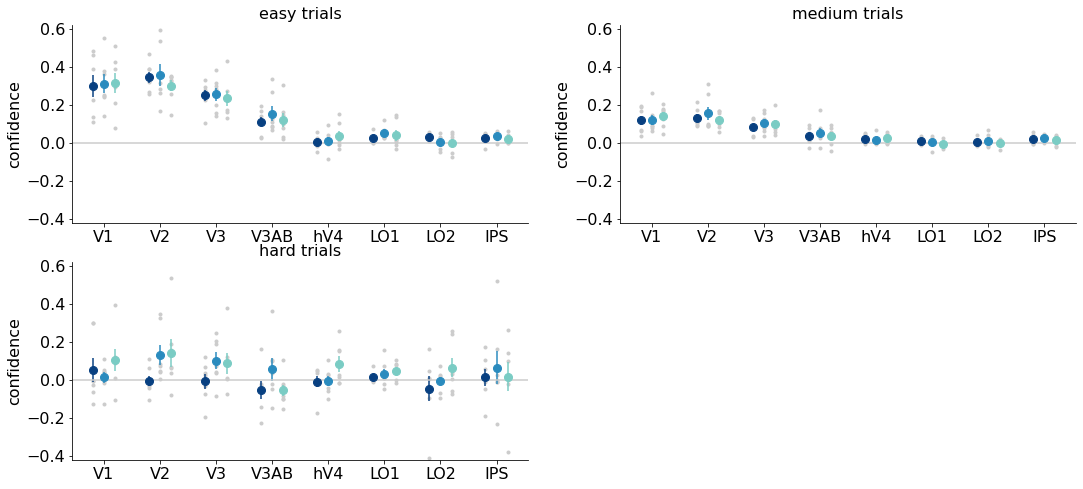

In [29]:
ti_plot = [0,1,2]

plt.figure(figsize=(18,8))

x_jitter = np.linspace(-0.2, 0.2, 3)

pi=0

for rvals, name in zip([conf_easytrials, conf_medtrials, conf_hardest,], \
                     ['easy trials','medium trials', 'hard trials']):

    pi+=1
    ax = plt.subplot(2,2,pi)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
        
        plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8,0.8], zorder=-10)

    ylims = [-0.42, 0.62]
    # ylims = [-0.2, 0.6]
    assert(np.all(rvals[:,:,ti_plot,:]>ylims[0]))
    assert(np.all(rvals[:,:,ti_plot,:]<ylims[1]))
    plt.ylim(ylims)

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    # plt.legend(lh,np.array(task_names)[ti_plot])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(name)

    # plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)

    figname = os.path.join(figfolder, 'checker_confidence.pdf')
    plt.savefig(figname)

In [15]:
for rvals, name in zip([conf_easytrials, conf_medtrials], \
                     ['easy trials','medium trials']):

    vals = rvals[:,:,:,0]

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('Anova for confidence w/r/t Checker, %s trials'%(name))
    print(anova_result)


Anova for confidence w/r/t Checker, easy trials trials
            F Value  Num DF  Den DF  Pr > F
roi       42.190647     7.0    42.0  0.0000
task       0.534460     2.0    12.0  0.5993
roi:task   0.596872    14.0    84.0  0.8604
Anova for confidence w/r/t Checker, medium trials trials
            F Value  Num DF  Den DF  Pr > F
roi       22.249921     7.0    42.0   0.000
task       0.739203     2.0    12.0   0.498
roi:task   0.778586    14.0    84.0   0.689


Text(0.5, 1.0, 'hard')

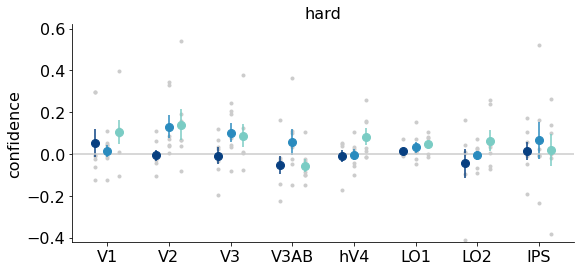

In [22]:
rvals = hardest
name = 'hard'

ti_plot = [0,1,2]

plt.figure(figsize=(9,4))
ax = plt.subplot(1,1,1)

x_jitter = np.linspace(-0.2, 0.2, 3)

plt.axhline(0, color=[0.8, 0.8, 0.8])

lh = []

for ti in ti_plot:

    x_ticks = np.arange(n_rois) + x_jitter[ti]

    vals = rvals[:,:,ti,ii]
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

    plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                 markersize=8)
    h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
    lh.append(h)

for ri in range(n_rois):

    plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8,0.8], zorder=-10)

ylims = [-0.42, 0.62]
# ylims = [-0.2, 0.6]
assert(np.all(rvals[:,:,ti_plot,:]>ylims[0]))
assert(np.all(rvals[:,:,ti_plot,:]<ylims[1]))
plt.ylim(ylims)

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('confidence')

# plt.legend(lh,np.array(task_names)[ti_plot])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title(name)

In [26]:
vals = hardest[:,:,:,0]

anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

print('Anova for confidence w/r/t Checker, hardest trials')
print(anova_result)


Anova for confidence w/r/t Checker, hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       2.245077     7.0    42.0  0.0493
task      1.346464     2.0    12.0  0.2968
roi:task  0.829688    14.0    84.0  0.6354


In [25]:
hardest.shape

(7, 8, 3, 1)

In [6]:
n_tasks = 3

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

ii = 0;

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        dist_from_center = l['dist_from_center'].round(2)
        
        categ_actual = np.array(l['categ_task3']).astype(int)
        
        un_dist = np.unique(dist_from_center[is_main_grid])
        
        is_hard = is_main_grid & (dist_from_center==un_dist[0])
        is_medium = is_main_grid & (dist_from_center==un_dist[1])
        is_easy = is_main_grid & (dist_from_center==un_dist[2])
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):

            pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

            coords_pred = grid_pts[pred,:]
            categ_pred = grid_utils.get_categ(coords_pred, 3)
            
            prob = dec_withintask['probs_all'][si][ri][ti]

            # "confidence" in assignment to category 2 vs 1
            # group the 16 points into categories w/r/t relevant axis
            g1 = grid_utils.get_categ(grid_pts, 3)==1
            p_categ1 = np.sum(prob[:,g1], axis=1)
            g2 = grid_utils.get_categ(grid_pts, 3)==2
            p_categ2 = np.sum(prob[:,g2], axis=1)

            # signed confidence will be: p(correct) - p(incorrect)
            signedconf = np.zeros_like(p_categ1)
            signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
            signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]


            # easy trials
            inds = is_easy & correct

            conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_easytrials[si,ri,ti,ii] = d;

            acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # medium trials
            inds = is_medium & correct

            conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_medtrials[si,ri,ti,ii] = d;

            acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # hard trials
            inds = is_hard & correct
            
            conf_hardtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_hardtrials[si,ri,ti,ii] = d;

            acc_hardtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])


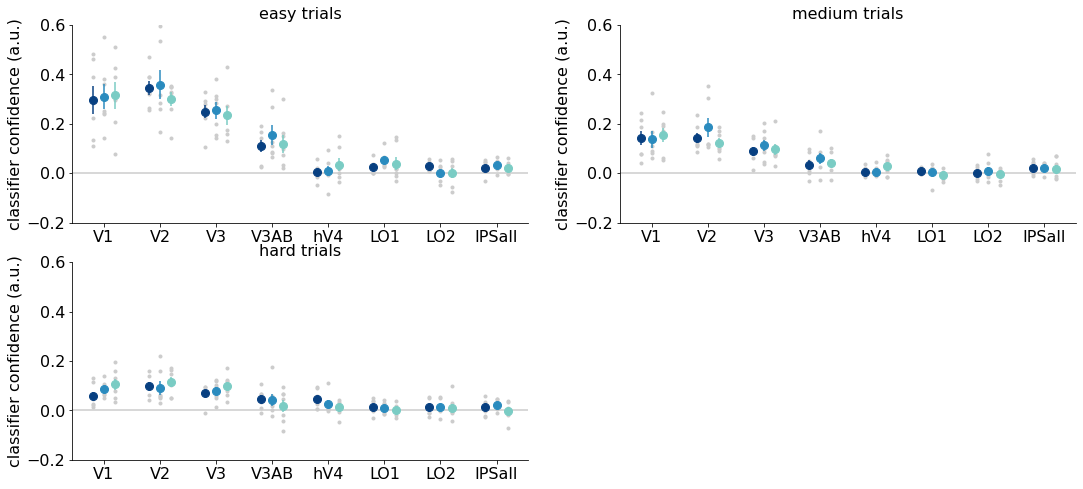

In [12]:
ti_plot = [0,1,2]

plt.figure(figsize=(18,8))

x_jitter = np.linspace(-0.2, 0.2, 3)

pi=0
# for rvals, name in zip([conf_easytrials, conf_medtrials, conf_hardtrials, hardest], \
                     # ['easy trials','medium trials', 'hard trials', 'hardest trials']):
for rvals, name in zip([conf_easytrials, conf_medtrials, conf_hardtrials], \
                     ['easy trials','medium trials', 'hard trials']):

    pi+=1
    ax = plt.subplot(2,2,pi)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
        
        plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8,0.8], zorder=-10)

    # ylims = [-0.42, 0.62]
    ylims = [-0.2, 0.6]
    assert(np.all(rvals[:,:,ti_plot,:]>ylims[0]))
    assert(np.all(rvals[:,:,ti_plot,:]<ylims[1]))
    plt.ylim(ylims)

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('classifier confidence (a.u.)')

    # plt.legend(lh,np.array(task_names)[ti_plot])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(name)

    # plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)

    

In [8]:
for rvals, name in zip([conf_easytrials, conf_medtrials, conf_hardtrials], \
                     ['easy trials','medium trials', 'hard trials']):

    vals = rvals[:,:,0:3,0]

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('Anova for confidence w/r/t Checker, %s trials'%(name))
    print(anova_result)


Anova for confidence w/r/t Checker, easy trials trials
            F Value  Num DF  Den DF  Pr > F
roi       42.190647     7.0    42.0  0.0000
task       0.534460     2.0    12.0  0.5993
roi:task   0.596872    14.0    84.0  0.8604
Anova for confidence w/r/t Checker, medium trials trials
            F Value  Num DF  Den DF  Pr > F
roi       22.262404     7.0    42.0  0.0000
task       1.287093     2.0    12.0  0.3116
roi:task   1.091647    14.0    84.0  0.3771
Anova for confidence w/r/t Checker, hard trials trials
            F Value  Num DF  Den DF  Pr > F
roi       12.235237     7.0    42.0  0.0000
task       0.008268     2.0    12.0  0.9918
roi:task   1.618548    14.0    84.0  0.0908


In [9]:
ii = 0;
axis_name = 'checker'
diffname = 'hard'

for ti_plot in [[0,2],[1,2]]:
    
    vals = conf_hardtrials[:,:,ti_plot,ii]
    
    tstats = np.zeros((n_rois,),dtype=float)
    pvals = np.zeros((n_rois,),dtype=float)
    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 6345456
    for rr in range(n_rois):

        vals1 = vals[:,rr,0]
        vals2 = vals[:,rr,1]

        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, \
                                               n_iter=10000, 
                                               # n_iter=2,
                                               rndseed=rndseed)    
        pvals[rr] = p
        tstats[rr] = t;

        # how many subjects go in same direction?
        subj_diffs = vals1-vals2
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    task_df = pd.DataFrame({'t-stat for %s > %s'%(task_names[ti_plot[0]], \
                                                  task_names[ti_plot[1]]): \
                            tstats, \
                            'pvalue': pvals, \
                            'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    print('\nclassify %s'%(axis_name))
    print('%s task > %s task'%(task_names[ti_plot[0]], task_names[ti_plot[1]]))

    print(task_df.round(3))


classify checker
Linear (1) task > Checker task
        t-stat for Linear (1) > Checker  pvalue  n_subs_indiv
V1                               -1.737   0.121             6
V2                               -1.137   0.427             4
V3                               -1.725   0.146             6
V3AB                              2.461   0.063             5
hV4                               1.867   0.136             5
LO1                               1.023   0.361             5
LO2                               0.173   0.853             4
IPSall                            0.991   0.434             4

classify checker
Linear (2) task > Checker task
        t-stat for Linear (2) > Checker  pvalue  n_subs_indiv
V1                               -0.957   0.412             4
V2                               -0.884   0.388             4
V3                               -1.869   0.075             5
V3AB                              0.763   0.488             4
hV4                               

In [83]:
n_tasks = 4

conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

# conf_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
# dprime_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
# acc_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

ii = 0;

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        dist = l['dist_from_bound3'].round(2)
        # dist_from_center = l['dist_from_center'].round(2)
        
        categ_actual = np.array(l['categ_task3']).astype(int)
        
        un_dist = np.unique(dist[is_main_grid])
        
        is_medium = is_main_grid & (dist==0.8)
        is_easy = is_main_grid & (dist==2.4)
        # print(np.sum(is_medium), np.sum(is_easy))
        # is_easy = is_main_grid & (dist_from_center==un_dist[2])
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):

            pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

            coords_pred = grid_pts[pred,:]
            categ_pred = grid_utils.get_categ(coords_pred, 3)
            
            prob = dec_withintask['probs_all'][si][ri][ti]

            # "confidence" in assignment to category 2 vs 1
            # group the 16 points into categories w/r/t relevant axis
            g1 = grid_utils.get_categ(grid_pts, 3)==1
            p_categ1 = np.sum(prob[:,g1], axis=1)
            g2 = grid_utils.get_categ(grid_pts, 3)==2
            p_categ2 = np.sum(prob[:,g2], axis=1)

            # signed confidence will be: p(correct) - p(incorrect)
            signedconf = np.zeros_like(p_categ1)
            signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
            signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

            
#             inds = is_main_grid & correct
                
#             conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])

#             d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
#             dprime_allmaintrials[si,ri,ti,ii] = d;

#             acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # easy trials
            inds = is_easy & correct

            conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_easytrials[si,ri,ti,ii] = d;

            acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # medium trials
            inds = is_medium & correct

            conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_medtrials[si,ri,ti,ii] = d;

            acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

#             # hard trials
#             inds = is_hard & correct
            
#             conf_hardtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

#             d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
#             dprime_hardtrials[si,ri,ti,ii] = d;

#             acc_hardtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])


In [62]:
conf_easytrials.shape

(7, 8, 4, 1)

In [81]:
np.unique(dist[is_main_grid])

array([0.8, 2.4])

In [79]:
np.mean(is_easy)

0.0

In [61]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_include_checker_bootstrap_correctonly.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_boot = b['signedconf_hardtrials_boot']

In [67]:
hardest = np.mean(signedconf_hardtrials_boot[:,:,:,2:3,:], axis=4)
hardest.shape

(7, 8, 3, 1)

In [62]:
conf_easytrials.shape

(7, 8, 4, 1)

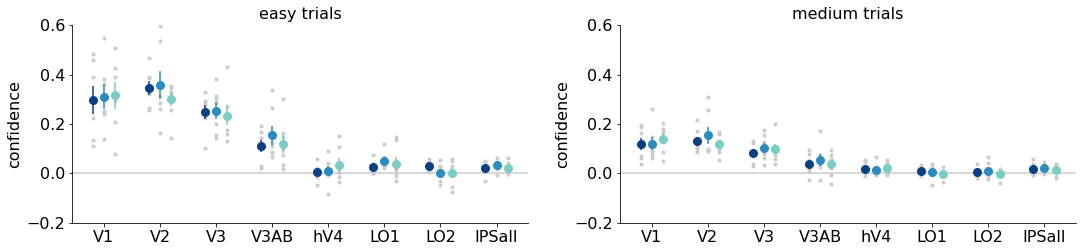

In [84]:
ti_plot = [0,1,2]

plt.figure(figsize=(18,8))

x_jitter = np.linspace(-0.2, 0.2, 3)

pi=0
# for rvals, name in zip([conf_easytrials, conf_medtrials, conf_hardtrials, hardest], \
                     # ['easy trials','medium trials', 'hard trials', 'hardest trials']):
for rvals, name in zip([conf_easytrials, conf_medtrials], \
                     ['easy trials','medium trials']):

    pi+=1
    ax = plt.subplot(2,2,pi)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
        
        plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8,0.8], zorder=-10)

    # ylims = [-0.42, 0.62]
    ylims = [-0.2, 0.6]
    assert(np.all(rvals[:,:,ti_plot,:]>ylims[0]))
    assert(np.all(rvals[:,:,ti_plot,:]<ylims[1]))
    plt.ylim(ylims)

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    # plt.legend(lh,np.array(task_names)[ti_plot])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(name)

    # plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)


In [86]:
for rvals, name in zip([conf_easytrials, conf_medtrials], \
                     ['easy trials','medium trials']):

    vals = rvals[:,:,:,0]

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('Anova for confidence w/r/t Checker, %s trials'%(name))
    print(anova_result)


Anova for confidence w/r/t Checker, easy trials trials
            F Value  Num DF  Den DF  Pr > F
roi       46.786491     7.0    42.0  0.0000
task       0.495768     3.0    18.0  0.6898
roi:task   0.748746    21.0   126.0  0.7748
Anova for confidence w/r/t Checker, medium trials trials
            F Value  Num DF  Den DF  Pr > F
roi       22.441084     7.0    42.0  0.0000
task       0.459509     3.0    18.0  0.7140
roi:task   0.862179    21.0   126.0  0.6388


In [85]:
conf_easytrials.shape

(7, 8, 4, 1)

In [69]:
np.max(hardest)

0.5381093279539427

In [70]:
np.min(hardest)

-0.4109841384053375

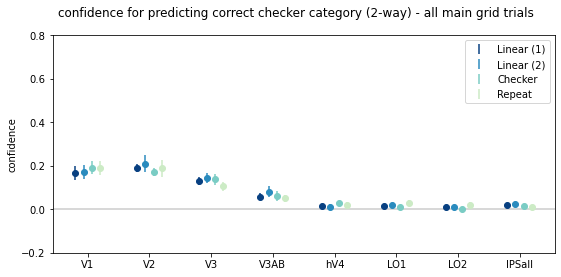

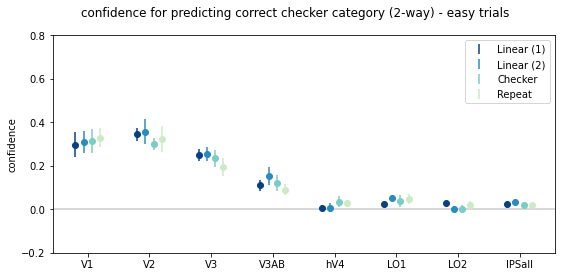

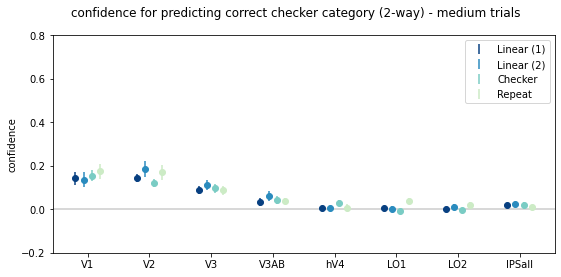

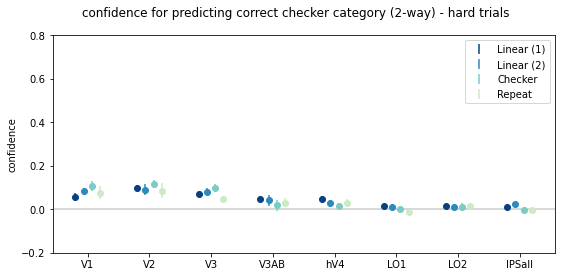

In [36]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for rvals, name in zip([conf_allmaintrials, conf_easytrials, conf_medtrials, conf_hardtrials], \
                     ['all main grid trials', 'easy trials','medium trials', 'hard trials']):

    plt.figure(figsize=(9,4))

    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([-0.2, 0.8])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)


In [30]:
vals.shape

(7, 4, 4)

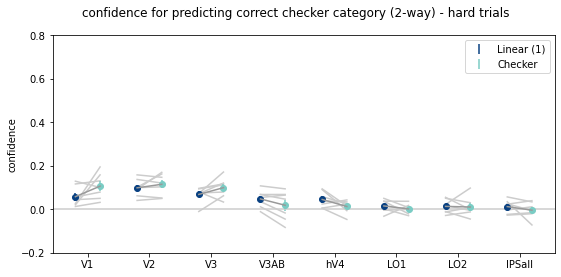

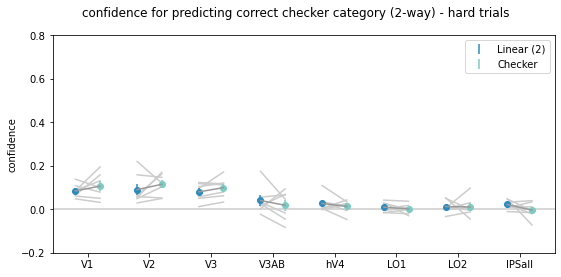

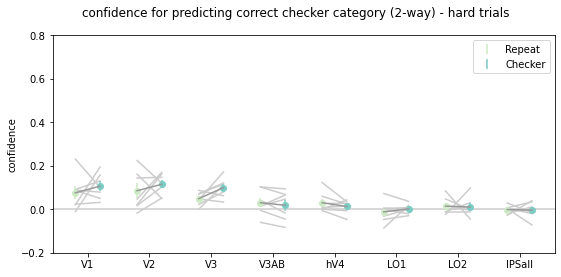

In [16]:
for ti_plot in [[0,2],[1,2],[3,2]]:


    x_jitter = np.linspace(-0.2, 0.2, 2)

    for rvals, name in zip([conf_hardtrials], \
                         ['hard trials']):

        plt.figure(figsize=(9,4))

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for tii, ti in enumerate(ti_plot):

            x_ticks = np.arange(n_rois) + x_jitter[tii]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)

        for ri in range(n_rois):

            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)


        plt.ylim([-0.2, 0.8])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)


In [28]:
ii = 0;
axis_name = 'checker'
diffname = 'hard'

for ti_plot in [[0,2],[1,2],[3,2]]:
    
    vals = conf_hardtrials[:,:,ti_plot,ii]
    
    print('\n%s vs %s'%(task_names[ti_plot[0]], task_names[ti_plot[1]]))
    
    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('Anova for confidence w/r/t %s, %s trials'%(axis_name, diffname))
    print(anova_result)



Linear (1) vs Checker
Anova for confidence w/r/t checker, hard trials
            F Value  Num DF  Den DF  Pr > F
roi       10.744649     7.0    42.0  0.0000
task       0.000281     1.0     6.0  0.9872
roi:task   3.391287     7.0    42.0  0.0058

Linear (2) vs Checker
Anova for confidence w/r/t checker, hard trials
            F Value  Num DF  Den DF  Pr > F
roi       13.127892     7.0    42.0  0.0000
task       0.007306     1.0     6.0  0.9347
roi:task   1.063993     7.0    42.0  0.4031

Repeat vs Checker
Anova for confidence w/r/t checker, hard trials
            F Value  Num DF  Den DF  Pr > F
roi       14.059976     7.0    42.0  0.0000
task       0.621171     1.0     6.0  0.4606
roi:task   0.982186     7.0    42.0  0.4570


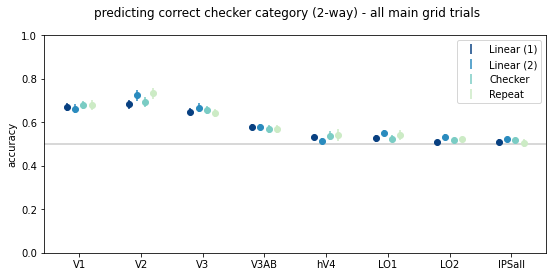

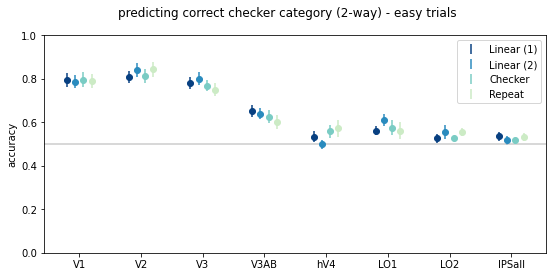

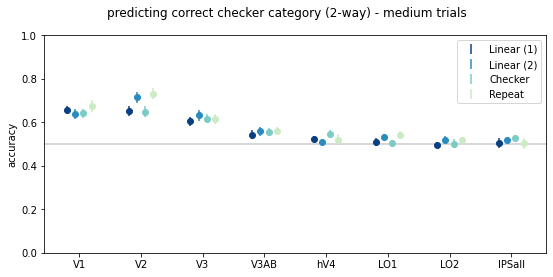

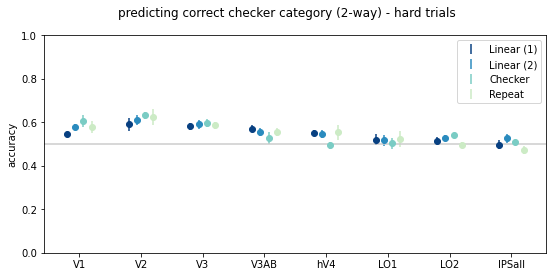

In [10]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for avals, name in zip([acc_allmaintrials, acc_easytrials, acc_medtrials, acc_hardtrials], \
                     ['all main grid trials', 'easy trials','medium trials', 'hard trials']):

    plt.figure(figsize=(9,4))

    plt.axhline(0.5, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([0,1])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('accuracy')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.suptitle('predicting correct checker category (2-way) - %s'%name)
